In [1]:
from model_vae import CVAE, cvae_loss
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import  DataLoader, Dataset
x_data = np.load('./data/metal.npy',allow_pickle = True)
c_data = np.load('./data/reaction.npy',allow_pickle = True)
sup_data = np.load('./data/support.npy',allow_pickle=True)
x_dim = x_data.shape[1]
c_dim = c_data.shape[1]
sup_dim = sup_data.shape[1]


FileNotFoundError: [Errno 2] No such file or directory: './data/metal.npy'

## 데이터 train,val,test 6:2:2로 일단 unshuffle로 나누기

In [ ]:
## train,test,validation_data 만들기
from sklearn.model_selection import train_test_split
x_train,x_test,c_train,c_test = train_test_split(x_data,c_data,test_size = 0.4,shuffle = False)
x_val,x_test,c_val,c_test = train_test_split(x_test,c_test,test_size = 0.5,shuffle= False)
print(x_train.shape,c_train.shape,x_test.shape) #0.6 #0.2 #0.2로 데이터 분류


(3544, 24) (3544, 9) (1182, 24)


# 데이터 scaler로 정리하기

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
scaler_c = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_val = scaler_x.transform(x_val)
x_test = scaler_x.transform(x_test)
c_train = scaler_c.fit_transform(c_train)
c_val = scaler_c.transform(c_val)
c_test = scaler_c.transform(c_test)

In [ ]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_val   = torch.tensor(x_val,   dtype=torch.float32)
x_test  = torch.tensor(x_test,  dtype=torch.float32)

c_train = torch.tensor(c_train, dtype=torch.float32)
c_val   = torch.tensor(c_val,   dtype=torch.float32)
c_test  = torch.tensor(c_test,  dtype=torch.float32)

## model에 넣고 학습시키기

In [ ]:
model = CVAE(x_dim = x_dim,c_dim = c_dim,z_dim = 16)
x_hat,mu, logvar = model(x_train,c_train)
# x_hat = x_hat.detach().cpu().numpy()
# x_hat = scaler_x.inverse_transform(x_hat)
# x_hat = torch.tensor(x_hat, dtype=torch.float32)
cvae_loss(x_hat,x_train,mu,logvar,beta = -0.01)

(tensor(0.7168, grad_fn=<AddBackward0>),
 tensor(0.7176, grad_fn=<MseLossBackward0>),
 tensor(0.0783, grad_fn=<MeanBackward0>))

## 다시 inverse해서 구하는 방식

In [ ]:
model = CVAE(x_dim = x_dim,c_dim = c_dim,z_dim = 16)
x_hat,mu, logvar = model(x_train,c_train)
x_hat = x_hat.detach().cpu().numpy()
x_hat = scaler_x.inverse_transform(x_hat)
x_hat = torch.tensor(x_hat, dtype=torch.float32)
cvae_loss(x_hat,x_train,mu,logvar,beta = -0.01)

(tensor(0.7146, grad_fn=<AddBackward0>),
 tensor(0.7158),
 tensor(0.1162, grad_fn=<MeanBackward0>))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64
learning_rate = 1e-3
z_dim = 16
epochs = 200
train_dataset = TensorDataset(x_train,c_train)
val_dataset = TensorDataset(x_val,c_val)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle = True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle = False)


In [ ]:
model.parameters()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 모델 초기화
model = CVAE(x_dim=x_dim, c_dim=c_dim, z_dim=z_dim).to(device)

# Optimizer 설정 (Adam이 일반적으로 가장 무난합니다)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    # --- 학습 모드 ---
    model.train()
    train_total_loss = 0
    
    for batch_x, batch_c in train_loader:
        batch_x, batch_c = batch_x.to(device), batch_c.to(device)
        
        optimizer.zero_grad() # 기울기 초기화
        
        # 순전파
        x_hat, mu, logvar = model(batch_x, batch_c)
        
        # 손실 계산 (beta 값을 조절하여 KL의 영향력을 제어할 수 있습니다)
        loss, recon, kl = cvae_loss(x_hat, batch_x, mu, logvar, beta=0.01)
        
        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()
        
        train_total_loss += loss.item()
    
    avg_train_loss = train_total_loss / len(train_loader)
    
    # --- 검증 모드 (오차가 실제로 줄어드는지 확인) ---
    model.eval()
    val_total_loss = 0
    with torch.no_grad():
        for v_x, v_c in val_loader:
            v_x, v_c = v_x.to(device), v_c.to(device)
            v_hat, v_mu, v_logvar = model(v_x, v_c)
            v_loss, _, _ = cvae_loss(v_hat, v_x, v_mu, v_logvar)
            val_total_loss += v_loss.item()
            
    avg_val_loss = val_total_loss / len(val_loader)
    
    # 결과 저장 및 출력
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch [{epoch}/{epochs}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
        

Epoch [1/200] Train Loss: 0.635375 | Val Loss: 10.450945
Epoch [20/200] Train Loss: 0.100979 | Val Loss: 23.305789
Epoch [40/200] Train Loss: 0.059104 | Val Loss: 19.783610
Epoch [60/200] Train Loss: 0.051928 | Val Loss: 17.220076
Epoch [80/200] Train Loss: 0.053342 | Val Loss: 16.999508
Epoch [100/200] Train Loss: 0.052785 | Val Loss: 15.505084
Epoch [120/200] Train Loss: 0.039301 | Val Loss: 16.122179
Epoch [140/200] Train Loss: 0.038873 | Val Loss: 16.394393
Epoch [160/200] Train Loss: 0.036000 | Val Loss: 18.587117
Epoch [180/200] Train Loss: 0.033577 | Val Loss: 15.538297
Epoch [200/200] Train Loss: 0.035278 | Val Loss: 16.325928


In [ ]:
max(train_losses)

0.6353753350142922

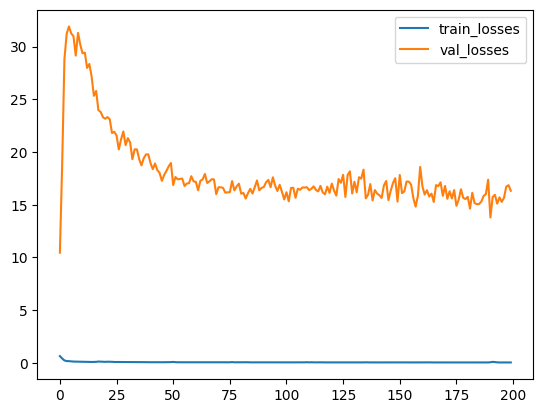

In [ ]:
import matplotlib.pyplot as plt
x_value = np.arange(len(train_losses))
plt.plot(x_value,train_losses,label = 'train_losses')
plt.plot(x_value,val_losses,label = 'val_losses')
plt.legend()
plt.show()